In [1]:
import os
# os.chdir("1_Programmieren II/Praesentation/voila")
# os.chdir("voila")
os.chdir("..")
os.getcwd()

'/Users/lwaetzig/Documents/B_Studium/2_SSM_1/A_Vorlesungsmaterial/1_Programmieren II/Praesentation/voila'

# IMPORTS

In [2]:
import datetime as dt
import json
import os
import statistics

import geopandas as gpd
import geopy
import ipywidgets as widgets
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import requests
from IPython.display import HTML, display , Image


# DECLAIRE GLOBAL VARIABLES

In [3]:
icons = {
    "Clear": "figures/sun.png",
    "Rain": "figures/rain.png",
    "sun_cloud": "figures/sun_cloud.png",
    "Clouds": "figures/cloud.png",
    "wind": "figures/wind.png",
}
# define global vairables
API_KEY = "0903f43c667c445d4a0c16920ef81c36"
SHAPE_FILE = "data/germany_geo.json"

## Layout

### Widgets

In [4]:
textfield = widgets.Text(value='Mannheim' , placeholder='Enter city name' , description="CITY NAME:")
display(textfield)

Text(value='Mannheim', description='CITY NAME:', placeholder='Enter city name')

In [5]:
def button_clicked(x):
    get_weather_data_city(api_key=API_KEY , city_name=textfield.value)
    
button = widgets.Button(description="refresh")
button.on_click(button_clicked)
display(button)

Button(description='refresh', style=ButtonStyle())

### HTML LAYOUT

In [6]:
# create Header using HTML
title='WEATHER DASHBOARD'
HTML('<h1 style="font-size:30px;"><center>%s</center></h1>'%title)

In [7]:
subtitle1="Weather in whole Germany"
HTML('<h2 style="font-size:24px;"><center>%s</center></h2>'%subtitle1)

In [8]:
value = str(textfield.value).upper()
subtitle2 = f"Forecast for next 24h in {value}"
HTML('<h2 style="font-size:24px;"><center>%s</center></h2>'%subtitle2)

In [9]:
value = str(textfield.value).upper()
subtitle3 = f"Next 7 days in {value}"
HTML('<h2 style="font-size:24px;"><center>%s</center></h2>'%subtitle3)

## Function to get weather data for one specific 
The following function requests data from openweather api, prepare and store them in a pd.DataFrame. You have to pass a name of a city located in germany and the api key (already definded at the top of the notebook)


In [10]:
def get_weather_data_city(api_key: str, city_name: str) -> dict:
    """function to get raw weather data for specific city

    Args:
        city_name (str): name of city in germany
        api_key (str): necessary authentification to create api request

    Returns:
        dict: dictionary with data raw weather data from api
    """

    # get longitude and latitude for given city
    service = geopy.Nominatim(user_agent="myGeocoder")
    Location = service.geocode(f"{city_name}, Germany")

    # try to request api and store weather data
    try:
        url = (
            "https://api.openweathermap.org/data/2.5/onecall?lat=%s&lon=%s&appid=%s&units=metric"
            % (Location.latitude, Location.longitude, api_key)
        )
        response = requests.get(url)
        data = json.loads(response.text)
    except Exception as e:
        print(f"something went wrong: {e}")

    # if there is a failure code in the dataset stop and return None
    if "cod" in data.keys():
        print(data["cod"], data["message"])
        return None
    else:
        return data


def get_granularity(data: dict, granularity: str) -> pd.DataFrame:
    """choose hourly data from weather data set and store in DataFrame

    Args:
        city_name (str): name of city in germany
        api_key (str): necessary authentification to create api request
        granularity (str): hourly and daily

    Returns:
        pd.DataFrame: filled DataFrame with weather data from api
    """

    # only select hourly data from api request
    timezone = data["timezone"]
    forecast = data[granularity]

    # create, fill DataFrame for weather data and set timestamps as index
    weather_df = pd.DataFrame()

    if granularity == "hourly":

        weather_df["date"] = [
            dt.datetime.fromtimestamp(entry["dt"], pytz.timezone(timezone))
            for entry in forecast
        ]
        weather_df["temp"] = [entry["temp"] for entry in forecast]
        weather_df["feels_like"] = [entry["feels_like"] for entry in forecast]
        weather_df["clouds"] = [entry["clouds"] for entry in forecast]
        weather_df["weather"] = [entry["weather"][0]["main"] for entry in forecast]
        weather_df = weather_df.set_index("date", drop=True)

    elif granularity == "daily":
        weather_df["date"] = [
            dt.datetime.fromtimestamp(entry["dt"], pytz.timezone(timezone))
            for entry in forecast
        ]
        weather_df["day_temp"] = [entry["temp"]["day"] for entry in forecast]
        weather_df["night_temp"] = [entry["temp"]["night"] for entry in forecast]
        weather_df["min_temp"] = [entry["temp"]["min"] for entry in forecast]
        weather_df["max_temp"] = [entry["temp"]["max"] for entry in forecast]
        weather_df["feels_like"] = [
            round(statistics.mean(
                (entry["feels_like"]["day"],
                entry["feels_like"]["night"],
                entry["feels_like"]["eve"],
                entry["feels_like"]["morn"])
            ) , 2)
            for entry in forecast
        ]
        weather_df["wind_speed"] = [entry["wind_speed"] for entry in forecast]
        weather_df["pressure"] = [entry["pressure"] for entry in forecast]
        weather_df["uvi"] = [entry["uvi"] for entry in forecast]
        weather_df["weather"] = [entry["weather"][0]["main"] for entry in forecast]
        weather_df["clouds"] = [entry["clouds"] for entry in forecast]
        weather_df = weather_df.set_index("date" , drop=True)

    return weather_df

### Vizualize data
-> using Matplotlib

In [11]:
# get and prepare data
data = get_weather_data_city(API_KEY, city_name= textfield.value)
df_daily = get_granularity(data , "daily")
df_hourly = get_granularity(data , "hourly")

#### Plot daily data #1

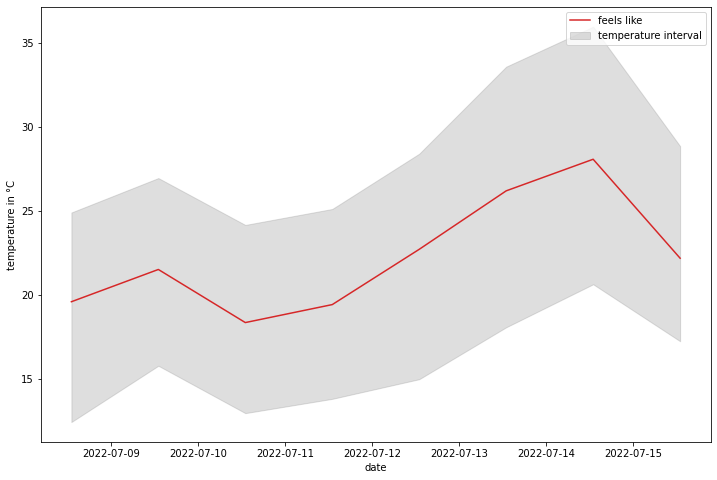

In [12]:
# plot whole df_daily content
fig , axis = plt.subplots(figsize=(12,8))
axis.plot(df_daily.index , df_daily["feels_like"] , color = "tab:red" , label = "feels like")
axis.fill_between(df_daily.index , df_daily["min_temp"] , df_daily["max_temp"] , color = "tab:grey" , alpha = 0.25 , label = "temperature interval")
axis.set_xlabel("date")
axis.set_ylabel("temperature in °C")
axis.legend();

#### Plot daily data #2

8.7.2022:
        Highest temperature: 24.9
        Lowest temperature: 12.43
        Feels like: 19.59
        UV-Index: 7.52
        Weather will be:


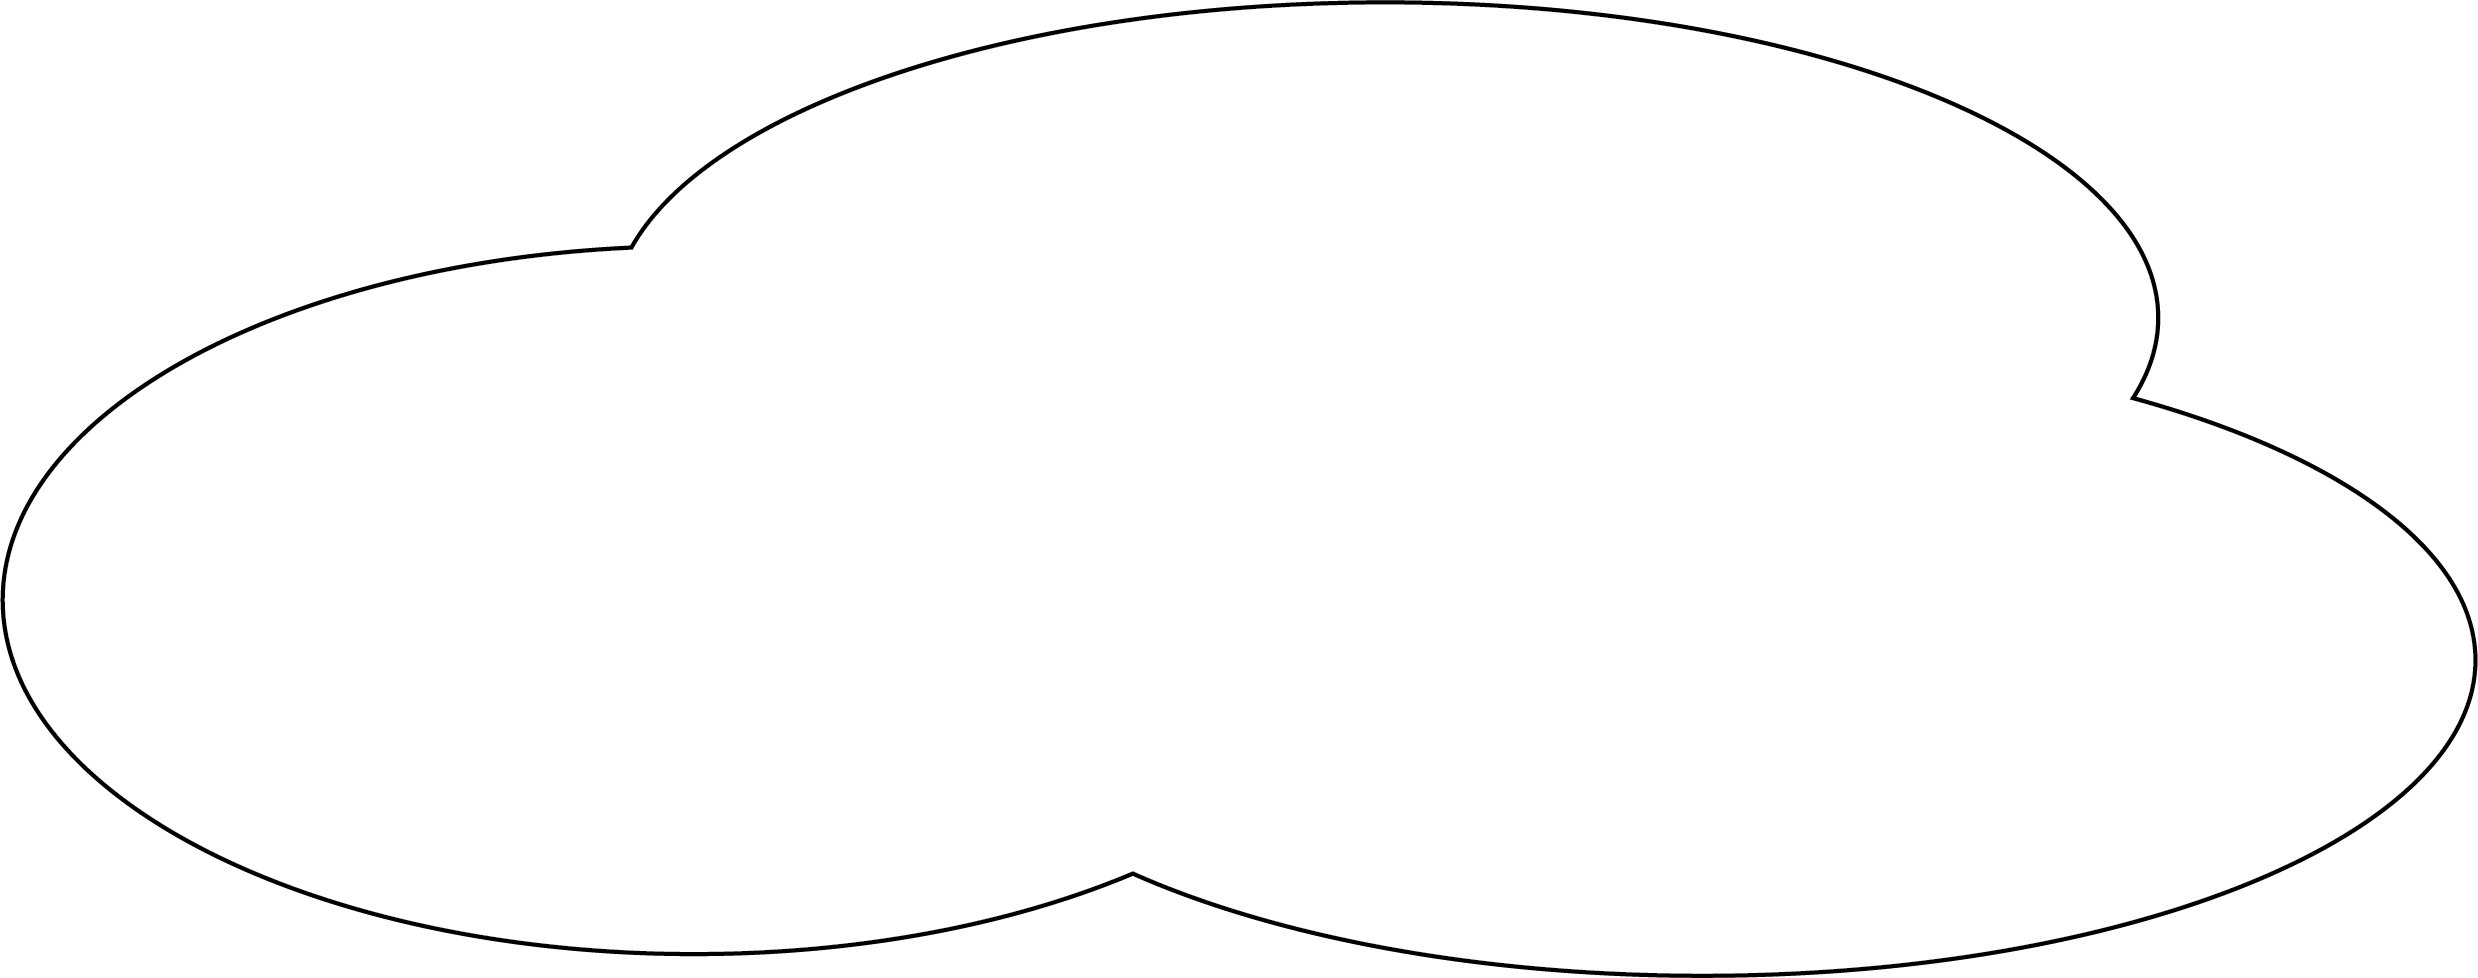

In [13]:
print(f"{df_daily.index.day[0]}.{df_daily.index.month[0]}.{df_daily.index.year[0]}:\n\
        Highest temperature: {df_daily['max_temp'][0]}\n\
        Lowest temperature: {df_daily['min_temp'][0]}\n\
        Feels like: {df_daily['feels_like'][0]}\n\
        UV-Index: {df_daily['uvi'][0]}\n\
        Weather will be:")
display(Image(filename=icons[df_daily["weather"][0]] , width=250 , height=250))

9.7.2022:
        Highest temperature: 26.95
        Lowest temperature: 15.78
        Feels like: 21.51
        UV-Index: 7.43
        Weather will be:


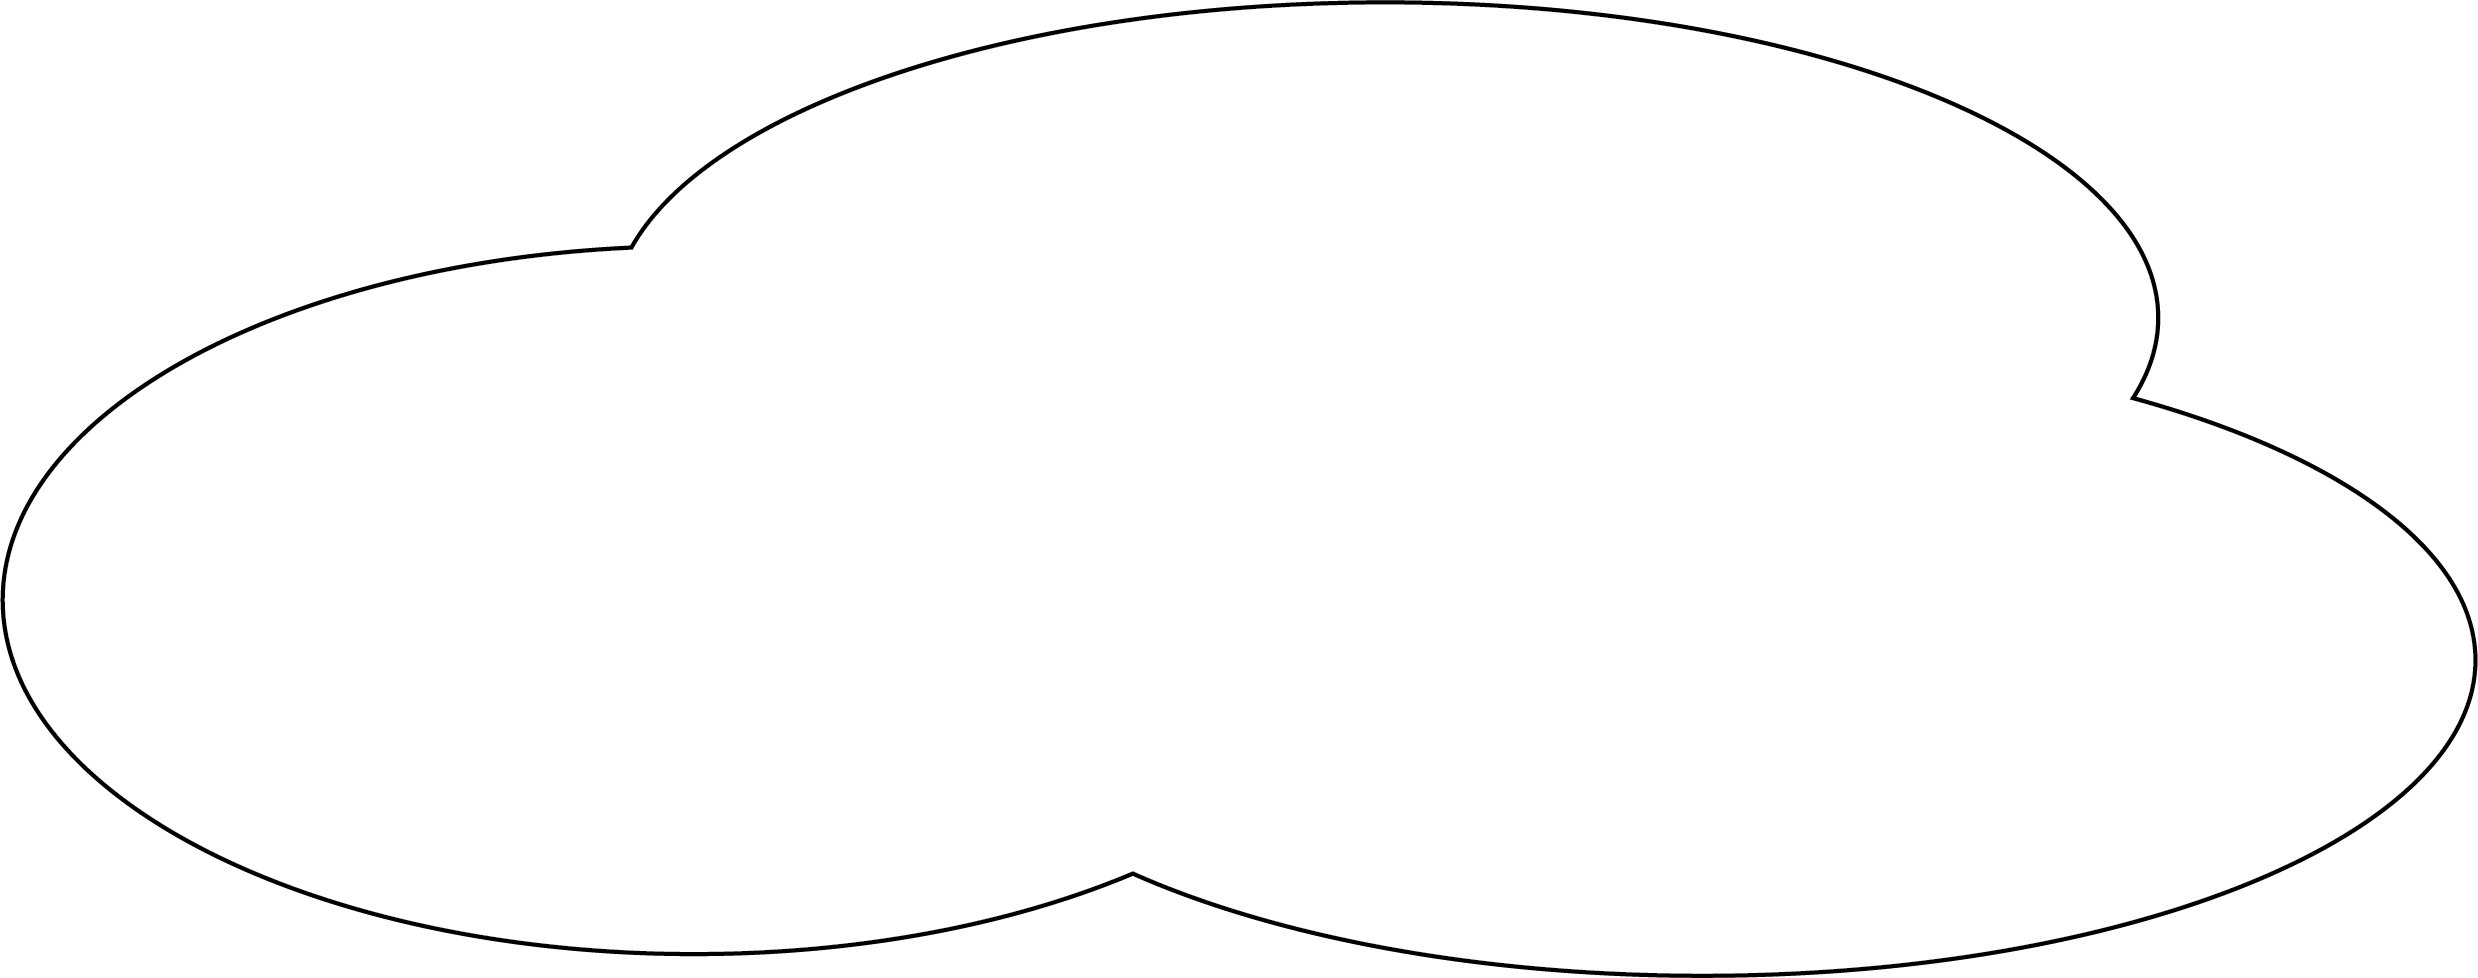

In [14]:
print(f"{df_daily.index.day[1]}.{df_daily.index.month[1]}.{df_daily.index.year[1]}:\n\
        Highest temperature: {df_daily['max_temp'][1]}\n\
        Lowest temperature: {df_daily['min_temp'][1]}\n\
        Feels like: {df_daily['feels_like'][1]}\n\
        UV-Index: {df_daily['uvi'][1]}\n\
        Weather will be:")
display(Image(filename=icons[df_daily["weather"][1]] , width=250 , height=250))

10.7.2022:
        Highest temperature: 24.16
        Lowest temperature: 12.96
        Feels like: 18.35
        UV-Index: 7.14
        Weather will be:


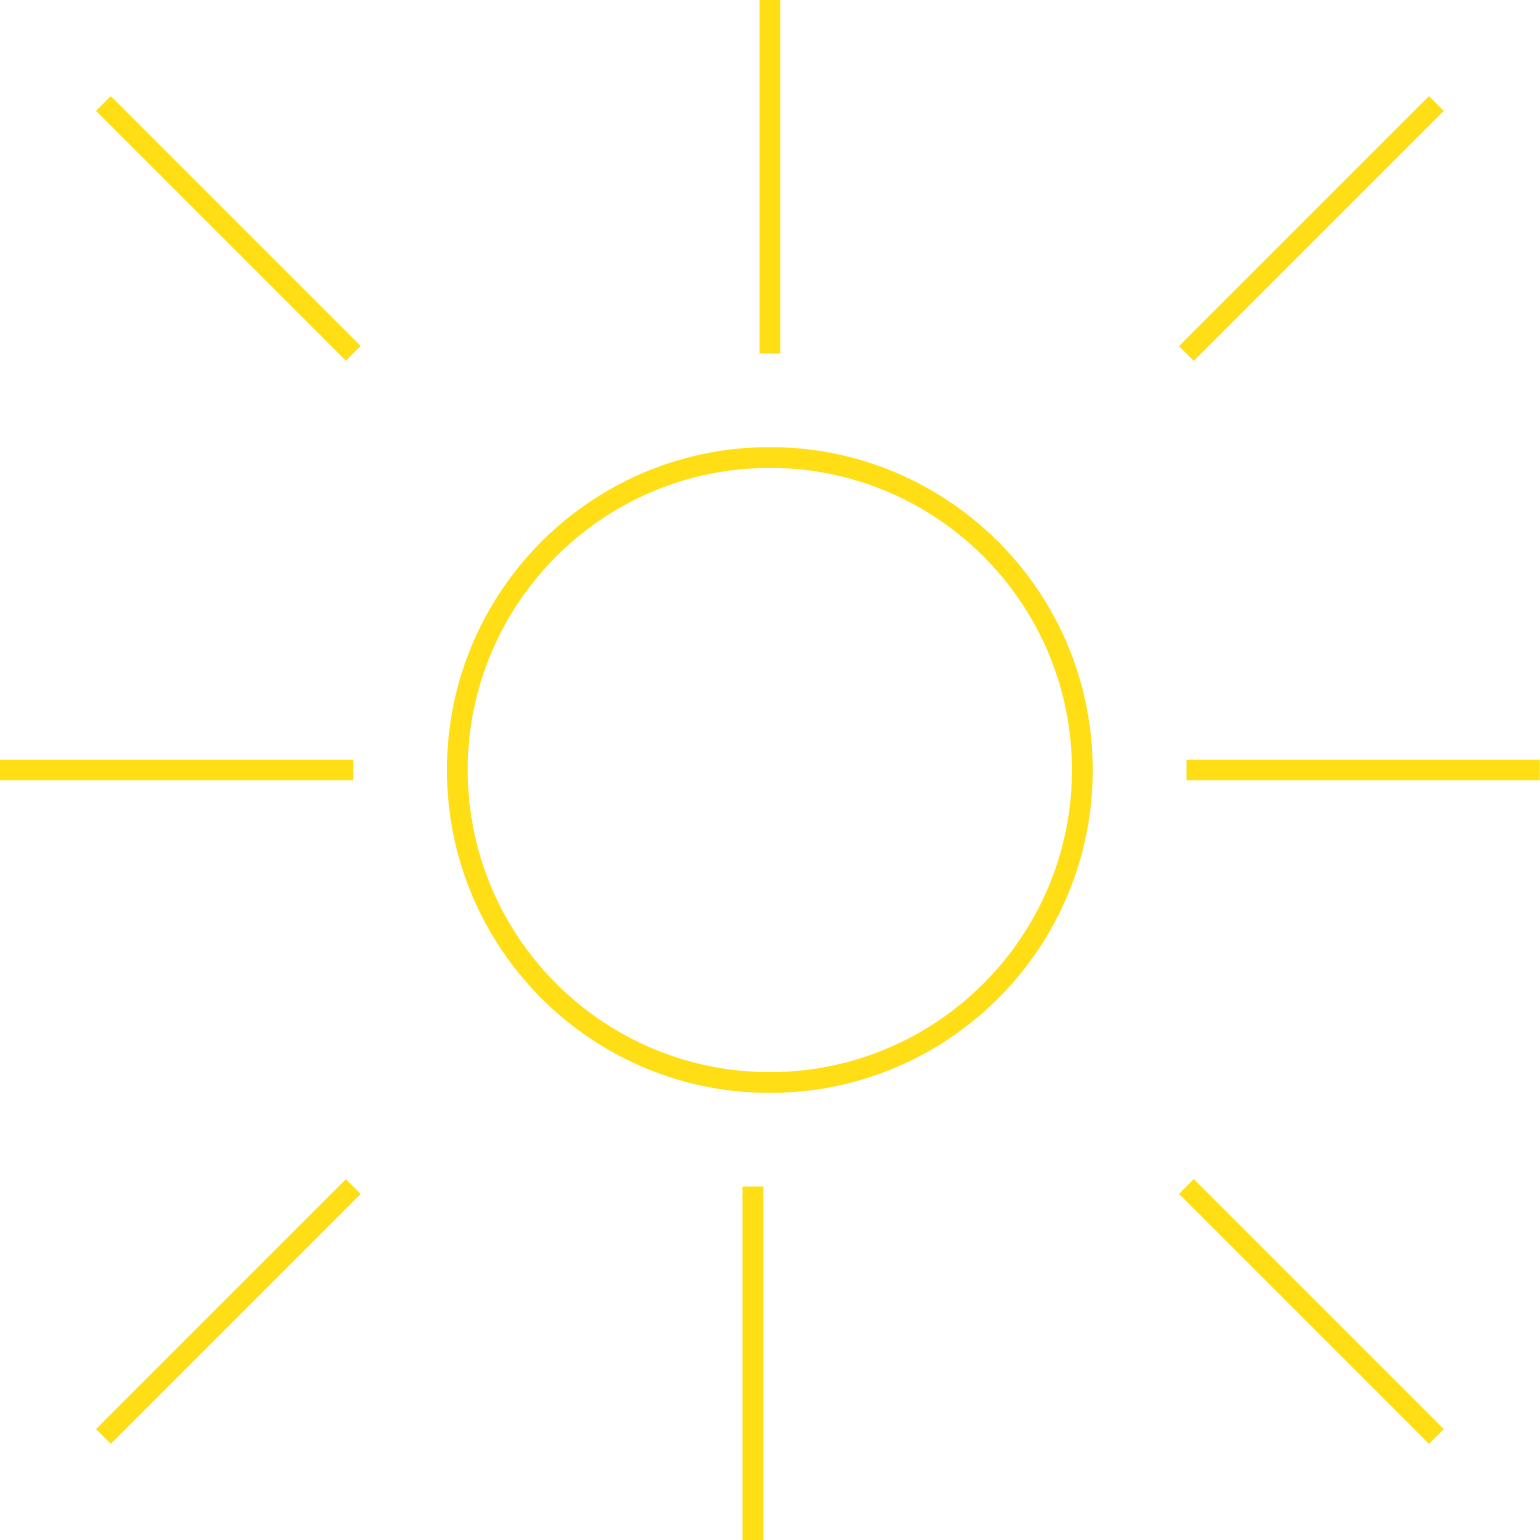

In [15]:
print(f"{df_daily.index.day[2]}.{df_daily.index.month[2]}.{df_daily.index.year[2]}:\n\
        Highest temperature: {df_daily['max_temp'][2]}\n\
        Lowest temperature: {df_daily['min_temp'][2]}\n\
        Feels like: {df_daily['feels_like'][2]}\n\
        UV-Index: {df_daily['uvi'][2]}\n\
        Weather will be:")
display(Image(filename=icons[df_daily["weather"][2]] , width=250 , height=250))

11.7.2022:
        Highest temperature: 25.11
        Lowest temperature: 13.81
        Feels like: 19.42
        UV-Index: 4.78
        Weather will be:


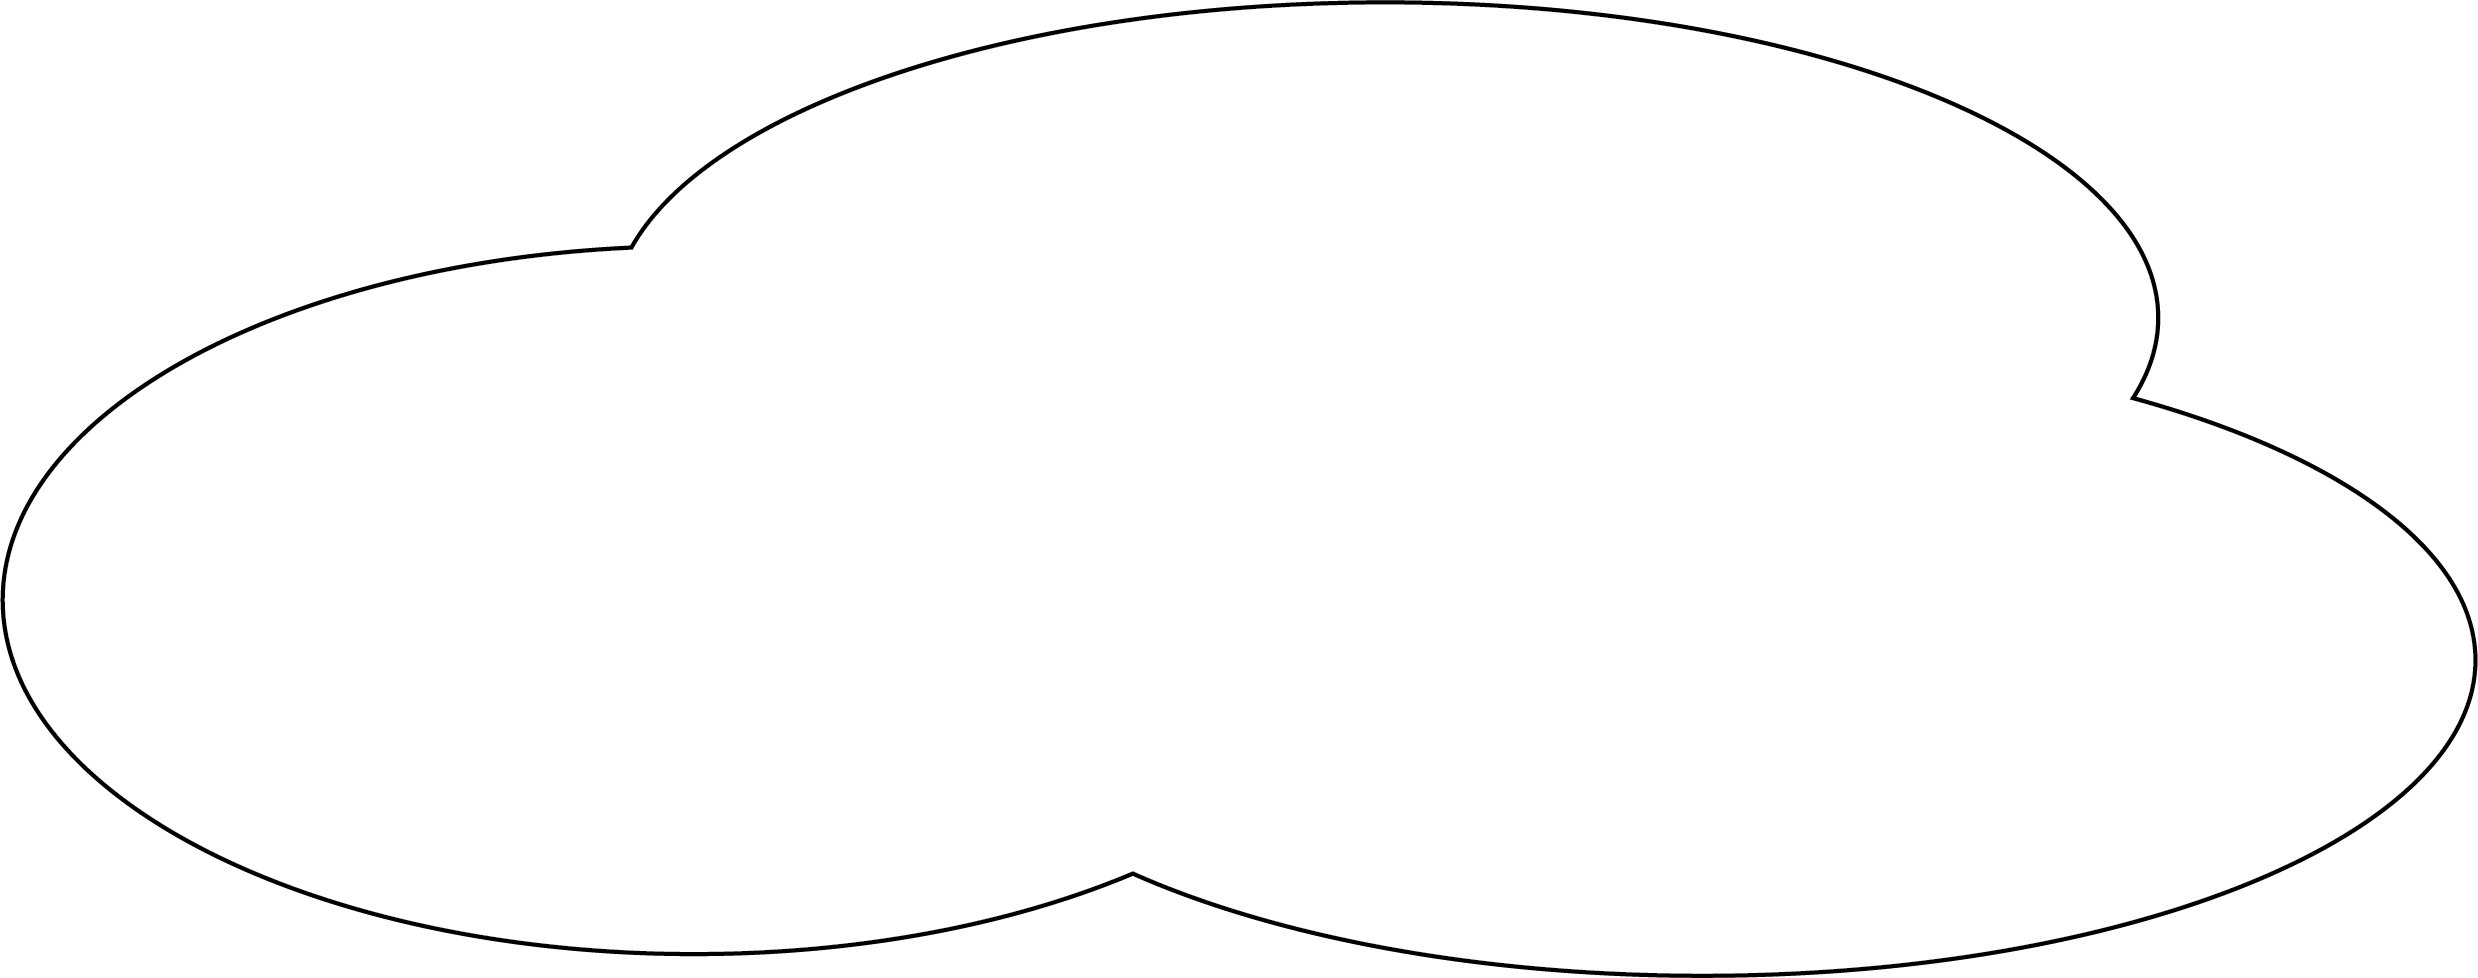

In [16]:
print(f"{df_daily.index.day[3]}.{df_daily.index.month[3]}.{df_daily.index.year[3]}:\n\
        Highest temperature: {df_daily['max_temp'][3]}\n\
        Lowest temperature: {df_daily['min_temp'][3]}\n\
        Feels like: {df_daily['feels_like'][3]}\n\
        UV-Index: {df_daily['uvi'][3]}\n\
        Weather will be:")
display(Image(filename=icons[df_daily["weather"][3]] , width=250 , height=250))

12.7.2022:
        Highest temperature: 28.4
        Lowest temperature: 14.98
        Feels like: 22.71
        UV-Index: 6.64
        Weather will be:


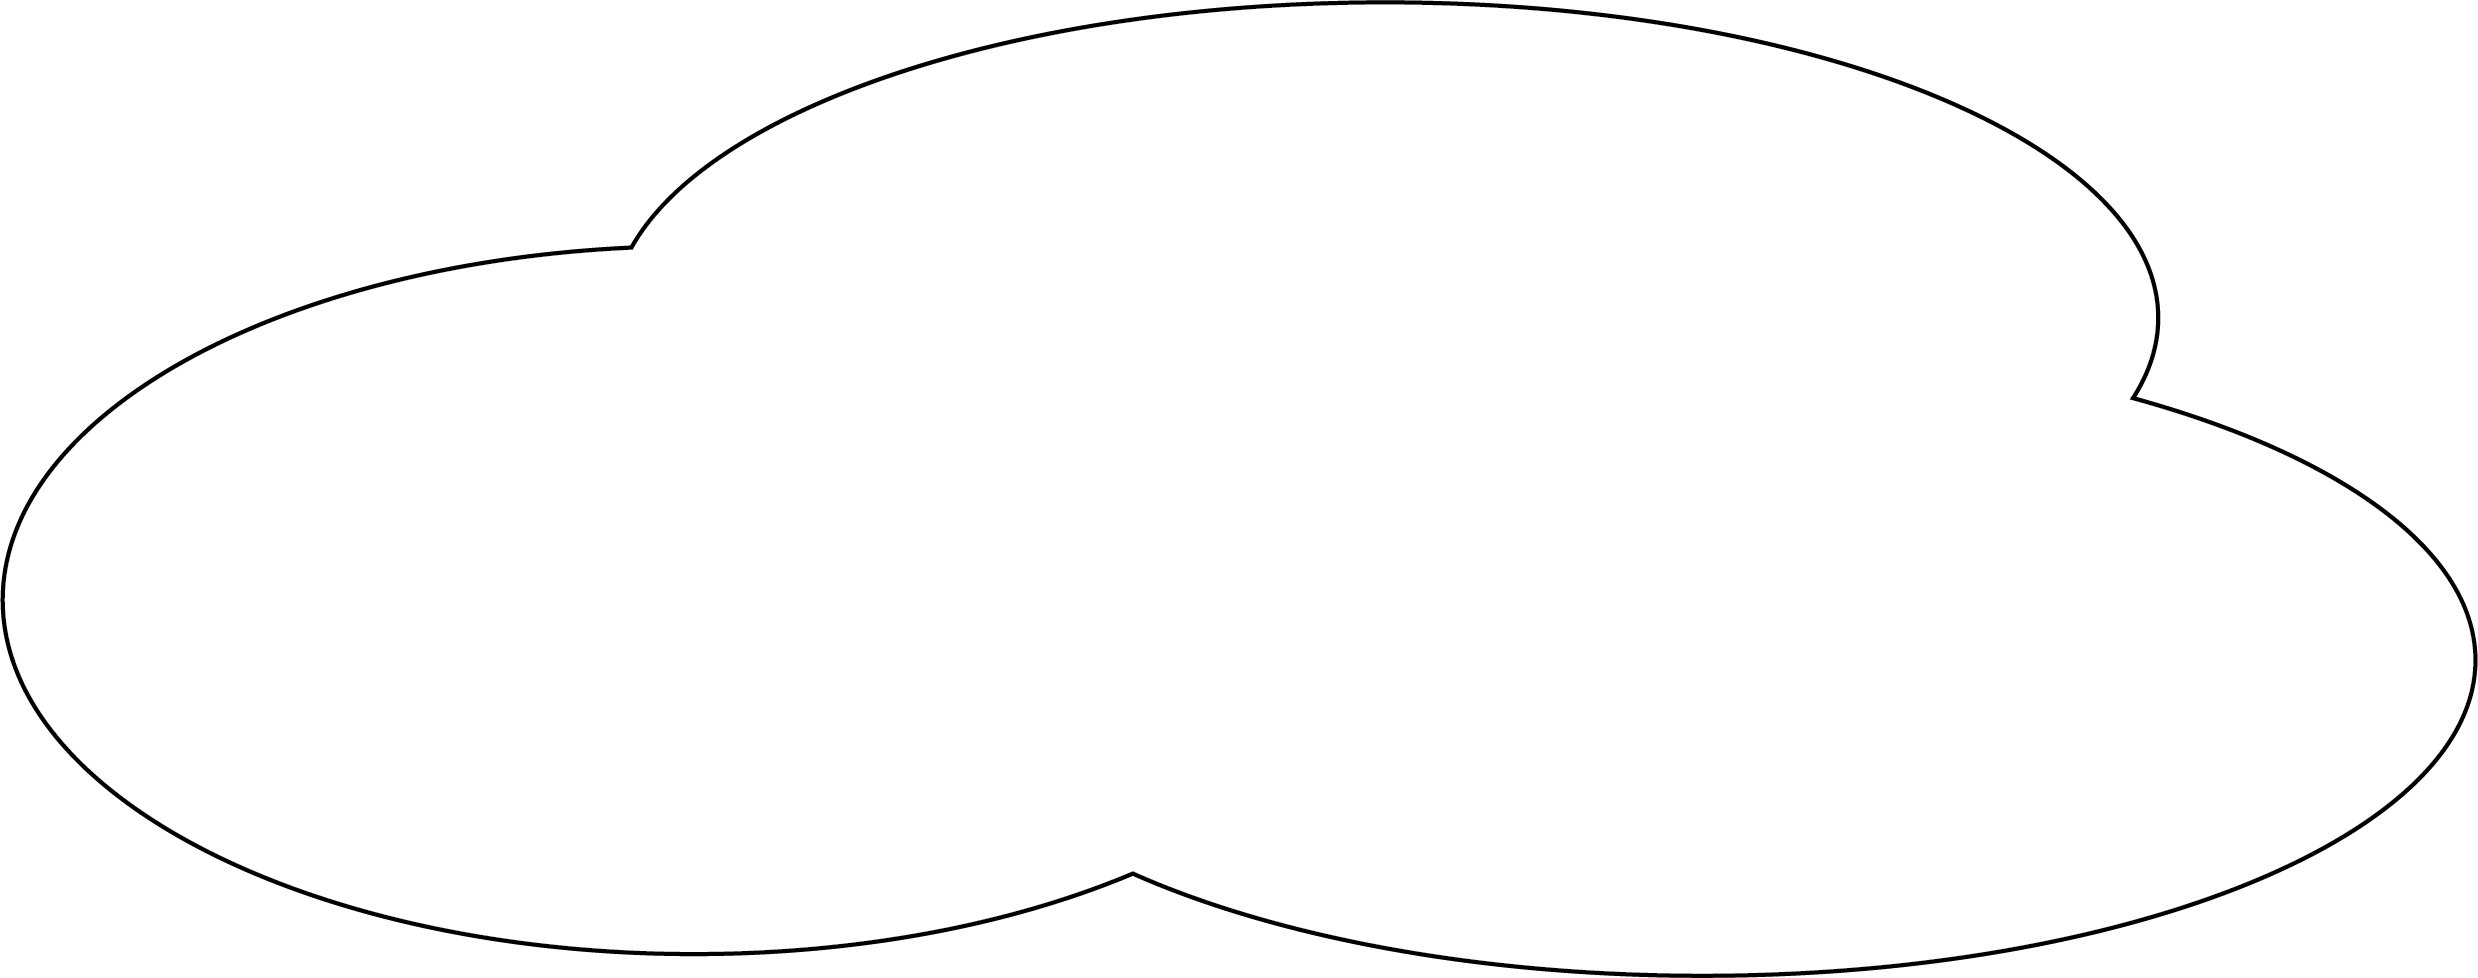

In [17]:
print(f"{df_daily.index.day[4]}.{df_daily.index.month[4]}.{df_daily.index.year[4]}:\n\
        Highest temperature: {df_daily['max_temp'][4]}\n\
        Lowest temperature: {df_daily['min_temp'][4]}\n\
        Feels like: {df_daily['feels_like'][4]}\n\
        UV-Index: {df_daily['uvi'][4]}\n\
        Weather will be:")
display(Image(filename=icons[df_daily["weather"][4]] , width=250 , height=250))

13.7.2022:
        Highest temperature: 33.58
        Lowest temperature: 18.07
        Feels like: 26.19
        UV-Index: 7.78
        Weather will be:


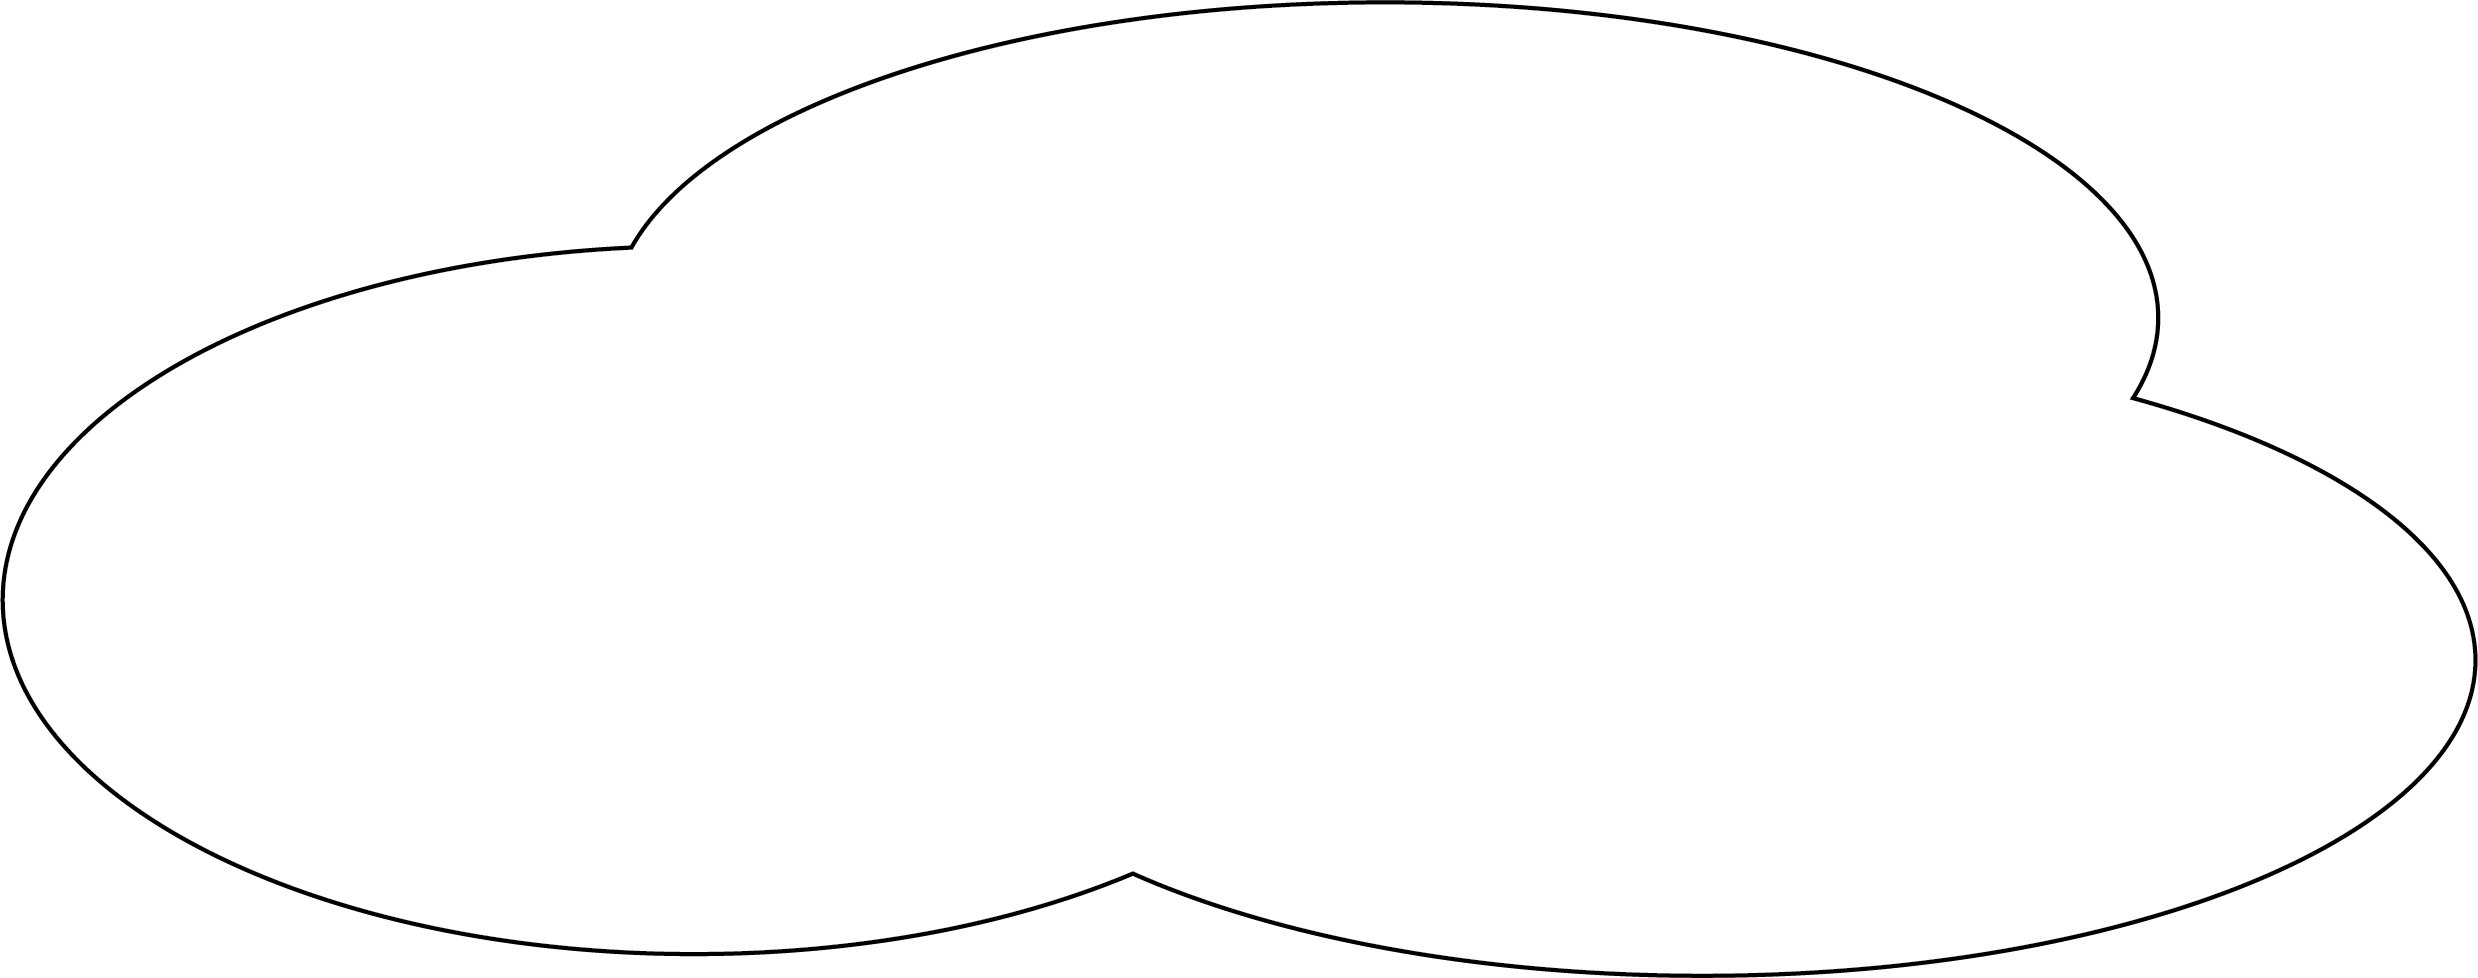

In [18]:
print(f"{df_daily.index.day[5]}.{df_daily.index.month[5]}.{df_daily.index.year[5]}:\n\
        Highest temperature: {df_daily['max_temp'][5]}\n\
        Lowest temperature: {df_daily['min_temp'][5]}\n\
        Feels like: {df_daily['feels_like'][5]}\n\
        UV-Index: {df_daily['uvi'][5]}\n\
        Weather will be:")
display(Image(filename=icons[df_daily["weather"][5]] , width=250 , height=250))

14.7.2022:
        Highest temperature: 35.96
        Lowest temperature: 20.63
        Feels like: 28.07
        UV-Index: 8.0
        Weather will be:


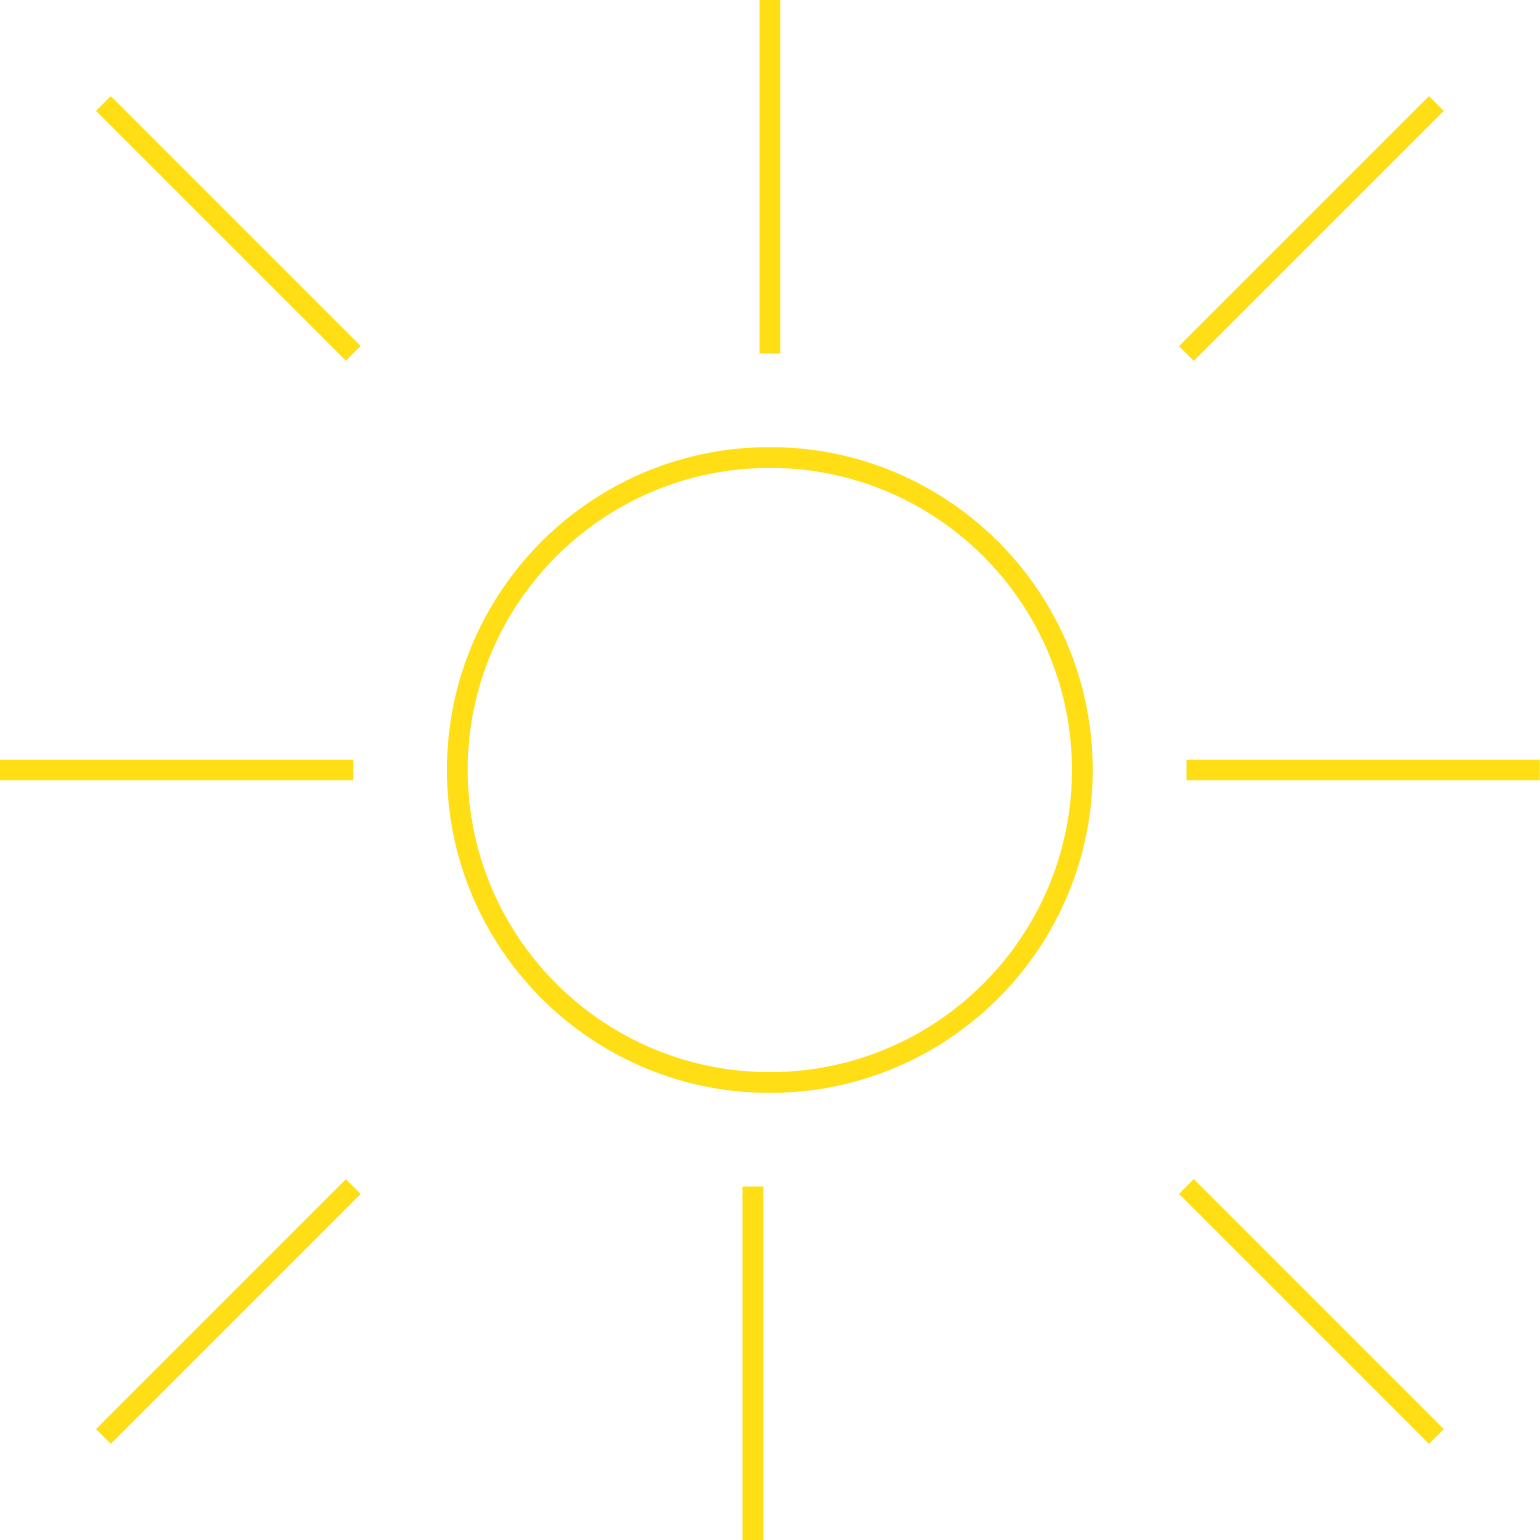

In [19]:
print(f"{df_daily.index.day[6]}.{df_daily.index.month[6]}.{df_daily.index.year[6]}:\n\
        Highest temperature: {df_daily['max_temp'][6]}\n\
        Lowest temperature: {df_daily['min_temp'][6]}\n\
        Feels like: {df_daily['feels_like'][6]}\n\
        UV-Index: {df_daily['uvi'][6]}\n\
        Weather will be:")
display(Image(filename=icons[df_daily["weather"][6]] , width=250 , height=250))

15.7.2022:
        Highest temperature: 28.85
        Lowest temperature: 17.24
        Feels like: 22.18
        UV-Index: 8.0
        Weather will be:


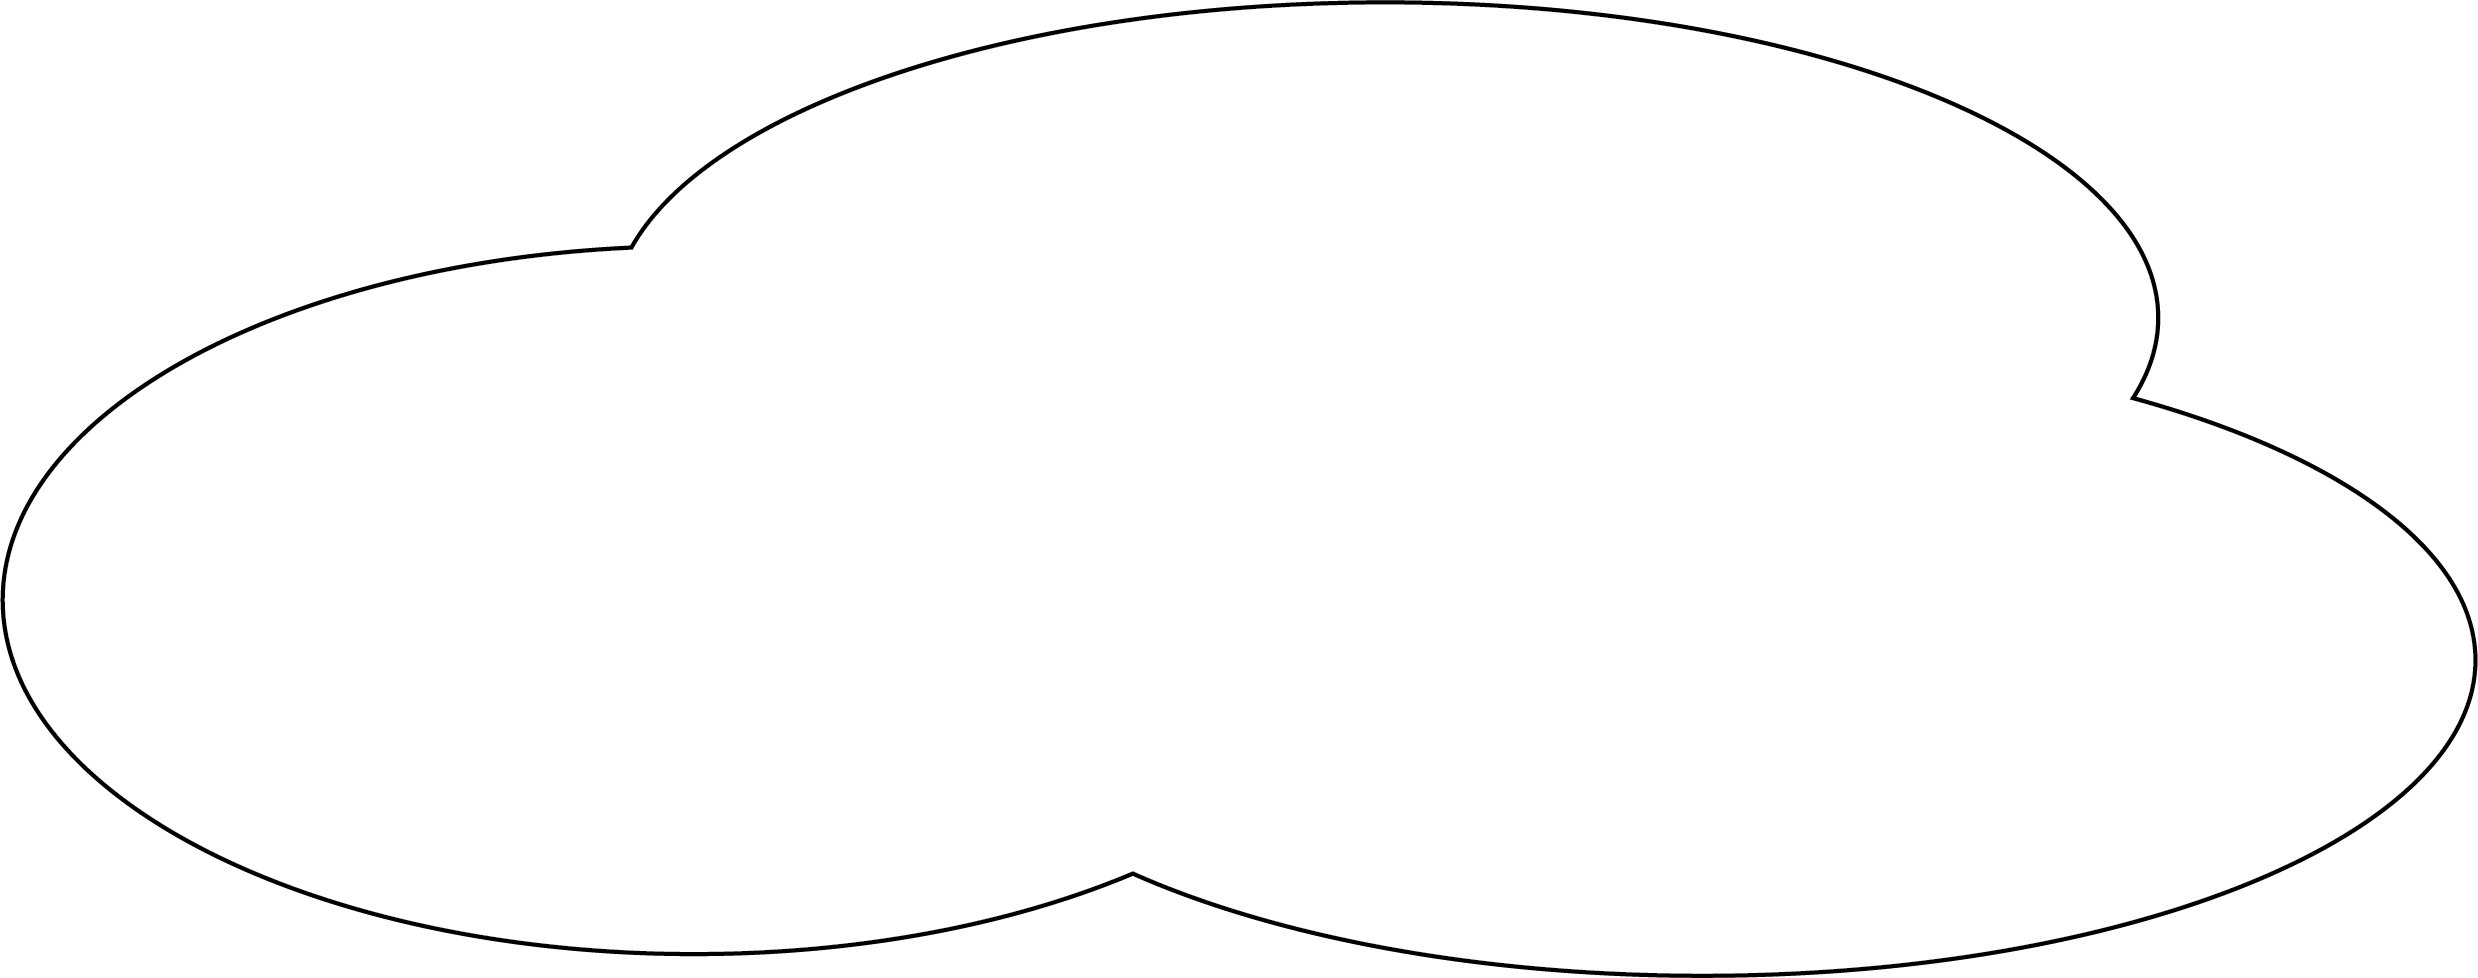

In [20]:
print(f"{df_daily.index.day[7]}.{df_daily.index.month[7]}.{df_daily.index.year[7]}:\n\
        Highest temperature: {df_daily['max_temp'][7]}\n\
        Lowest temperature: {df_daily['min_temp'][7]}\n\
        Feels like: {df_daily['feels_like'][7]}\n\
        UV-Index: {df_daily['uvi'][7]}\n\
        Weather will be:")
display(Image(filename=icons[df_daily["weather"][7]] , width=250 , height=250))

#### Plot hourly data

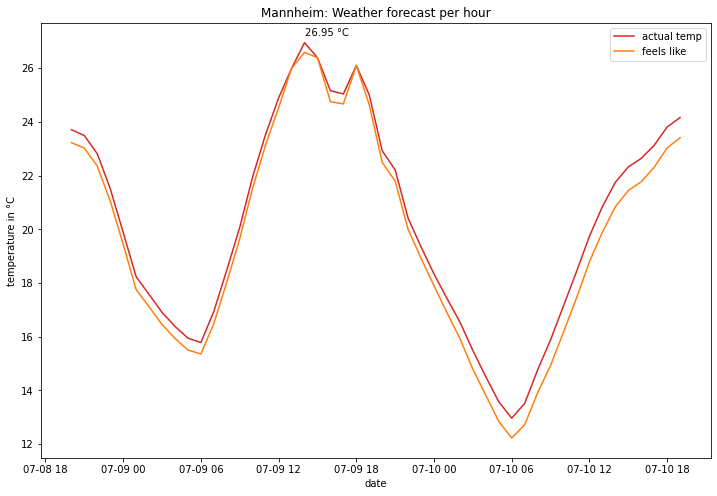

In [21]:
# get local maximum
ymax = max(df_hourly["temp"])
xpos = np.where(df_hourly["temp"] == ymax)
xmax = df_hourly.index[xpos]

# create figure to plot
fig, axis = plt.subplots(figsize=(12, 8))
# add two plots for temperature and feels like
axis.plot(df_hourly.index, df_hourly["temp"], color="tab:red", label="actual temp")
axis.plot(df_hourly.index, df_hourly["feels_like"], color="tab:orange", label="feels like")
axis.set_title(f"{textfield.value}: Weather forecast per hour")
axis.set_ylabel("temperature in °C")
axis.set_xlabel("date")
axis.legend(loc="upper right")
axis.annotate(
    f"{ymax} °C",
    xy=(xmax, ymax),
    xytext=(xmax, ymax + 0.25),
);


## Weather data for whole Germany
The following function requests data from openweather api depending on the capital for each federal state, prepare and store the data in pd.DataFrame. The DataFrame also contains geological data of germany to visualize the weather data.

In [22]:
def get_weather_data_germany(
    api_key: str,
    shape_file: str,
) -> pd.DataFrame:
    """get geological data using shapefile and weather data using api request from openweather-api

    Args:
        api_key (str): necessary authentification to create api request
        shape_file (str): shape file for germany map used to plot with geopandas

    Returns:
        pd.DataFrame: prepared DataFrame
    """

    # read in shapefile and remove unnecessary columns
    germany = gpd.read_file(shape_file)
    germany = germany.drop(columns=["type", "id"])

    # add capitals for each federal state
    capital = [
        "Stuttgart",
        "Muenchen",
        "Berlin",
        "Potsdam",
        "Bremen",
        "Hamburg",
        "Wiesbaden",
        "Schwerin",
        "Hannover",
        "Düsseldorf",
        "Mainz",
        "Saarbrücken",
        "Magdeburg",
        "Dresden",
        "Kiel",
        "Erfurt",
    ]
    germany["capital"] = capital

    # get latitude and longitude for each capital and append it to DataFrame
    service = geopy.Nominatim(user_agent="myGeocoder")
    for i, row in germany.iterrows():
        location = service.geocode(f"{row['capital']}, Germany")
        germany.loc[i, "lat"] = location.latitude
        germany.loc[i, "lon"] = location.longitude

    # get current weather data for each capital in DataFrame
    for i, row in germany.iterrows():
        try:
            url = (
                "https://api.openweathermap.org/data/2.5/onecall?lat=%s&lon=%s&appid=%s&units=metric"
                % (row["lat"], row["lon"], api_key)
            )
            response = requests.get(url)
            data = json.loads(response.text)
        except Exception as e:
            print(e)

        # if there is a failue code in dataset continue with next city
        if "cod" in data.keys():
            print(row["name"], data["message"])
            continue

        # fill DataFrame with weather data from api request
        else:
            germany.loc[i, "temp"] = data["current"]["temp"]
            germany.loc[i, "feels_like"] = data["current"]["feels_like"]
            germany.loc[i, "weather_type"] = data["current"]["weather"][0]["main"]
            germany.loc[i, "pressure"] = data["current"]["pressure"]
            germany.loc[i, "uvi"] = data["current"]["uvi"]
            germany.loc[i, "clouds"] = data["current"]["clouds"]

    return germany

### Vizualize Germany-map
-> using geopandas

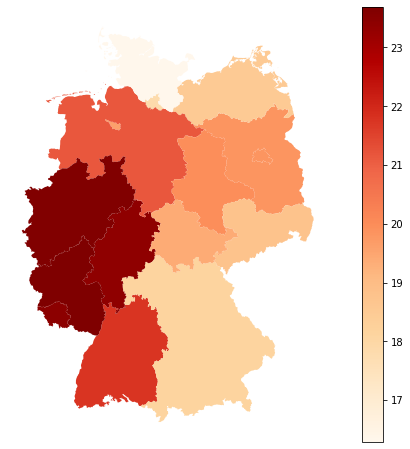

In [23]:
df_germany = get_weather_data_germany(API_KEY, SHAPE_FILE)
df_germany.plot(column="temp", cmap="OrRd" , figsize=(12,8) , legend=True).set_axis_off()